#Setup & Imports

In [ ]:
!pip install segmentation-models-pytorch==0.3.3 albumentations==1.4.3 torchmetrics==1.3.2 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.9 MB/s eta 0:00:00


In [ ]:
import random, os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt

# Seed setup for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

#Dataset Preparation

In [ ]:
class ISICDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        """
        Custom Dataset class for ISIC skin lesion segmentation.

        Args:
            images_dir (str): Path to directory containing input images
            masks_dir (str): Path to directory containing segmentation masks
            transform (albumentations.Compose, optional): Albumentations transforms for data augmentation
        """
        # Store directory paths for images and masks
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        # Store data augmentation transforms
        self.transform = transform

        # Only load valid image files - filter for JPG files and sort for consistency
        self.images = sorted([
            f for f in os.listdir(images_dir)
            if f.lower().endswith('.jpg')  # Case-insensitive check for JPG extension
        ])

    def __len__(self):
        """Return the total number of images in the dataset"""
        return len(self.images)

    def __getitem__(self, idx):
        """Get a single image-mask pair from the dataset by index"""
        # Get image filename and full path
        image_name = self.images[idx]
        image_path = os.path.join(self.images_dir, image_name)

        # Construct mask filename based on ISIC dataset naming convention
        # Mask name matches ISIC pattern: ISIC_XXXX_Segmentation.png
        base_name = os.path.splitext(image_name)[0]  # Remove file extension
        mask_name = base_name + "_Segmentation.png"  # Append segmentation suffix
        mask_path = os.path.join(self.masks_dir, mask_name)

        # --- Read image and mask using OpenCV ---
        # Read image in BGR format and convert to RGB
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read mask as grayscale (single channel)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # Check if mask was successfully loaded
        if mask is None:
            raise FileNotFoundError(f"Mask not found for {image_name} at {mask_path}")

        # Convert mask to binary format (0 or 1) with float32 data type
        # Threshold at 127: pixels > 127 become 1, others become 0
        mask = (mask > 127).astype('float32')

        # --- Apply data augmentation transforms if provided ---
        if self.transform:
            # Apply albumentations transforms to both image and mask simultaneously
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']  # Transformed image
            mask = augmented['mask'].unsqueeze(0)  # Add channel dimension: shape becomes (1, H, W)
        else:
            # If no transforms, convert to PyTorch tensors with proper normalization and dimensions
            # Convert image to tensor, change dimension order from (H,W,C) to (C,H,W), normalize to [0,1]
            image = torch.tensor(image).permute(2, 0, 1).float() / 255.
            # Convert mask to tensor and add channel dimension
            mask = torch.tensor(mask).unsqueeze(0)

        # Return the image-mask pair as PyTorch tensors
        return image, mask

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define image size for model input
img_size = 256
# Path to the main data directory
# Andrew's path: "/content/drive/MyDrive/7- CMPE 258 Deep Learning/Project/CMPE258-Project/Dataset"
data_dir = "/content/drive/MyDrive/7- CMPE 258 Deep Learning/Project/CMPE258-Project/Dataset"

# Training data transformations with heavy augmentation
train_transform = A.Compose([
    # Resize all images to consistent dimensions
    A.Resize(img_size, img_size),
    # Random horizontal flip with 50% probability
    A.HorizontalFlip(p=0.5),
    # Random vertical flip with 50% probability
    A.VerticalFlip(p=0.5),
    # Random affine transformations: shift, scale, and rotate
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    # Random brightness and contrast adjustments with 20% probability
    A.RandomBrightnessContrast(p=0.2),
    # Normalize with ImageNet statistics (common practice)
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    # Convert numpy arrays to PyTorch tensors
    ToTensorV2(),
])

# Validation data transformations (minimal, no augmentation)
val_transform = A.Compose([
    # Resize to same dimensions as training for consistency
    A.Resize(img_size, img_size),
    # Same normalization as training (important!)
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    # Convert to tensors
    ToTensorV2(),
])

# Test data transformations (minimal, no augmentation)
test_transform = A.Compose([
    # Resize to same dimensions as training for consistency
    A.Resize(img_size, img_size),
    # Same normalization as training (important!)
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    # Convert to tensors
    ToTensorV2()
])

# Create full training dataset with training transforms
full_train_dataset = ISICDataset(
    os.path.join(data_dir, "ISBI2016_ISIC_Part1_Training_Data/ISBI2016_ISIC_Part1_Training_Data"),              # Path to training images
    os.path.join(data_dir, "ISBI2016_ISIC_Part1_Training_GroundTruth/ISBI2016_ISIC_Part1_Training_GroundTruth"),       # Path to training masks
    transform=train_transform                    # Apply training augmentations
)

# Split full dataset into training and validation sets
val_ratio = 0.2  # 20% of data for validation
val_size = int(len(full_train_dataset) * val_ratio)
train_size = len(full_train_dataset) - val_size

# Randomly split the dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# IMPORTANT: Replace transform of val_dataset with validation transforms
# This ensures no data augmentation is applied during validation
val_dataset.dataset.transform = val_transform

# Create DataLoaders for efficient batch processing
train_loader = DataLoader(
    train_dataset,
    batch_size=8,           # Process 8 samples at once
    shuffle=True,           # Shuffle training data each epoch
    num_workers=2           # Use 2 parallel processes for data loading
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,           # Same batch size for consistency
    shuffle=False,          # No need to shuffle validation data
    num_workers=2           # Same number of workers
)

test_dataset = ISICDataset(
    os.path.join(data_dir, "ISBI2016_ISIC_Part1_Test_Data/ISBI2016_ISIC_Part1_Test_Data"),              # Path to training images
    os.path.join(data_dir, "ISBI2016_ISIC_Part1_Test_GroundTruth/ISBI2016_ISIC_Part1_Test_GroundTruth"),       # Path to training masks
    transform=test_transform  # No augmentation for test; resize & normalize only
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,           # Same batch size for consistency
    shuffle=False,          # No need to shuffle validation data
    num_workers=2           # Same number of workers
)

# Determine the computing device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("No GPU available, using CPU")

GPU Name: NVIDIA A100-SXM4-40GB
GPU Memory: 39.6 GB


# Define U-Net with ResNet34 Encoder

In [ ]:
# Create a U-Net model with ResNet34 encoder
unet_resnet34 = smp.Unet(
    encoder_name="resnet34",        # Use ResNet34 as the encoder/backbone
    encoder_weights="imagenet",     # Initialize with ImageNet pre-trained weights
    in_channels=3,                  # Input has 3 channels (RGB images)
    classes=1,                      # Output has 1 channel (binary segmentation)
    activation=None                 # No final activation (raw logits output)
).to(device)                        # Move model to specified device (GPU)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 176MB/s]


#Define Attention U-Net with ResNet34 Encoder

In [ ]:
# Create an Attention U-Net model with ResNet34 encoder
attention_unet = smp.Unet(
    encoder_name="resnet34",        # Use ResNet34 as the encoder/backbone
    encoder_weights="imagenet",     # Initialize with ImageNet pre-trained weights
    in_channels=3,                  # Input has 3 channels (RGB images)
    classes=1,                      # Output has 1 channel (binary segmentation)
    activation=None,                # No final activation (raw logits output)
    decoder_attention_type='scse'   # Add Spatial and Channel SE attention gates
).to(device)                        # Move model to specified device (GPU)

#Training

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-4, save_path="best_model.pth"):
    """
    Train a segmentation model and save the best checkpoint based on validation Dice.
    Returns metrics for plotting and best Dice score.
    """
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits (no sigmoid needed)
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer with specified learning rate

    # Define evaluation metrics
    dice_metric = BinaryF1Score().to(device)  # Dice coefficient (F1 score) for binary segmentation
    iou_metric = BinaryJaccardIndex().to(device)  # Intersection over Union (Jaccard Index) metric

    # Lists to store metrics for plotting
    train_losses, val_losses, val_dices, val_ious = [], [], [], []

    # Variables to track best model performance
    best_dice = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())  # Deep copy of initial model weights

    # Training loop over epochs
    for epoch in range(num_epochs):
        # --- TRAINING PHASE ---
        model.train()  # Set model to training mode
        train_loss = 0.0  # Accumulator for training loss

        # Iterate through training batches with progress bar
        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            # Move data to device (GPU/CPU)
            imgs, masks = imgs.to(device), masks.to(device)

            # Forward pass: compute predictions
            preds = model(imgs)
            # Compute loss between predictions and ground truth masks
            loss = criterion(preds, masks)

            # Backward pass and optimization
            optimizer.zero_grad()  # Clear previous gradients
            loss.backward()        # Compute gradients via backpropagation
            optimizer.step()       # Update model parameters

            # Accumulate training loss
            train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # --- VALIDATION PHASE ---
        model.eval()  # Set model to evaluation mode
        val_loss, val_dice, val_iou = 0.0, 0.0, 0.0  # Accumulators for validation metrics

        # Disable gradient computation for validation (faster, less memory)
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                preds = model(imgs)

                # Validation loss
                loss = criterion(preds, masks)
                val_loss += loss.item()

                # Compute metrics: apply sigmoid to get probabilities [0,1]
                preds_sigmoid = torch.sigmoid(preds)
                val_dice += dice_metric(preds_sigmoid, masks).item()  # Dice score
                val_iou += iou_metric(preds_sigmoid, masks).item()    # IoU score

        # Calculate average validation metrics
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)

        # Store validation metrics for plotting
        val_losses.append(avg_val_loss)
        val_dices.append(avg_val_dice)
        val_ious.append(avg_val_iou)

        # --- MODEL CHECKPOINTING ---
        # Save model if it achieves the best Dice score so far
        if avg_val_dice > best_dice:
            best_dice = avg_val_dice
            best_model_wts = copy.deepcopy(model.state_dict())  # Save best weights
            torch.save(best_model_wts, save_path)  # Save to file
            print(f"New best model saved! Dice = {best_dice:.4f}")

        # --- EPOCH LOGGING ---
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} "
              f"Val Loss: {avg_val_loss:.4f} "
              f"Val Dice: {avg_val_dice:.4f} "
              f"Val IoU: {avg_val_iou:.4f}")

    # --- TRAINING COMPLETION ---
    # Load the best performing model weights from training
    model.load_state_dict(best_model_wts)
    print(f"\nTraining complete! Best Validation Dice: {best_dice:.4f}")

    # --- VISUALIZATION ---
    # Create plots to visualize training progress
    plt.figure(figsize=(12,4))

    # Plot 1: Loss curves
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('BCE Loss')
    plt.legend()

    # Plot 2: Validation metrics
    plt.subplot(1,2,2)
    plt.plot(val_dices, label='Val Dice')
    plt.plot(val_ious, label='Val IoU')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return all metrics for further analysis
    return train_losses, val_losses, val_dices, val_ious, best_dice

Epoch 1/20 [Train]: 100%|██████████| 90/90 [07:24<00:00,  4.94s/it]


New best model saved! Dice = 0.8174
Epoch [1/20] Train Loss: 0.5825 Val Loss: 0.4319 Val Dice: 0.8174 Val IoU: 0.6932


Epoch 2/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.12it/s]


New best model saved! Dice = 0.8838
Epoch [2/20] Train Loss: 0.4332 Val Loss: 0.4053 Val Dice: 0.8838 Val IoU: 0.7932


Epoch 3/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.07it/s]


New best model saved! Dice = 0.9021
Epoch [3/20] Train Loss: 0.3967 Val Loss: 0.3878 Val Dice: 0.9021 Val IoU: 0.8226


Epoch 4/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.19it/s]


New best model saved! Dice = 0.9113
Epoch [4/20] Train Loss: 0.3761 Val Loss: 0.3665 Val Dice: 0.9113 Val IoU: 0.8379


Epoch 5/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.21it/s]


Epoch [5/20] Train Loss: 0.3456 Val Loss: 0.3512 Val Dice: 0.9106 Val IoU: 0.8366


Epoch 6/20 [Train]: 100%|██████████| 90/90 [00:16<00:00,  5.37it/s]


New best model saved! Dice = 0.9120
Epoch [6/20] Train Loss: 0.3273 Val Loss: 0.3300 Val Dice: 0.9120 Val IoU: 0.8392


Epoch 7/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch [7/20] Train Loss: 0.3093 Val Loss: 0.3310 Val Dice: 0.9096 Val IoU: 0.8349


Epoch 8/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.05it/s]


Epoch [8/20] Train Loss: 0.2908 Val Loss: 0.3131 Val Dice: 0.9030 Val IoU: 0.8244


Epoch 9/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.10it/s]


New best model saved! Dice = 0.9205
Epoch [9/20] Train Loss: 0.2725 Val Loss: 0.2838 Val Dice: 0.9205 Val IoU: 0.8534


Epoch 10/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.14it/s]


Epoch [10/20] Train Loss: 0.2560 Val Loss: 0.2653 Val Dice: 0.9154 Val IoU: 0.8448


Epoch 11/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.25it/s]


Epoch [11/20] Train Loss: 0.2414 Val Loss: 0.2634 Val Dice: 0.9172 Val IoU: 0.8478


Epoch 12/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.27it/s]


New best model saved! Dice = 0.9209
Epoch [12/20] Train Loss: 0.2256 Val Loss: 0.2467 Val Dice: 0.9209 Val IoU: 0.8541


Epoch 13/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.18it/s]


Epoch [13/20] Train Loss: 0.2099 Val Loss: 0.2416 Val Dice: 0.9200 Val IoU: 0.8527


Epoch 14/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.26it/s]


Epoch [14/20] Train Loss: 0.1983 Val Loss: 0.2368 Val Dice: 0.9174 Val IoU: 0.8482


Epoch 15/20 [Train]: 100%|██████████| 90/90 [00:16<00:00,  5.35it/s]


Epoch [15/20] Train Loss: 0.1871 Val Loss: 0.2178 Val Dice: 0.9135 Val IoU: 0.8417


Epoch 16/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.15it/s]


Epoch [16/20] Train Loss: 0.1759 Val Loss: 0.2127 Val Dice: 0.9121 Val IoU: 0.8397


Epoch 17/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.04it/s]


Epoch [17/20] Train Loss: 0.1631 Val Loss: 0.2075 Val Dice: 0.9206 Val IoU: 0.8537


Epoch 18/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.03it/s]


Epoch [18/20] Train Loss: 0.1530 Val Loss: 0.1931 Val Dice: 0.9150 Val IoU: 0.8441


Epoch 19/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.20it/s]


Epoch [19/20] Train Loss: 0.1444 Val Loss: 0.2037 Val Dice: 0.9111 Val IoU: 0.8380


Epoch 20/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.29it/s]


Epoch [20/20] Train Loss: 0.1369 Val Loss: 0.2022 Val Dice: 0.9158 Val IoU: 0.8454

Training complete! Best Validation Dice: 0.9209


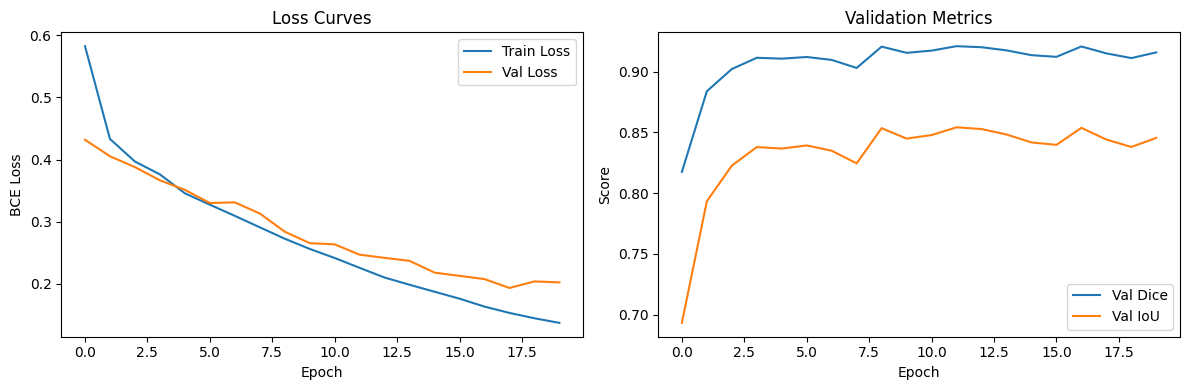

In [ ]:
# Train the U-Net with ResNet34 encoder model
train_losses_unet, val_losses_unet, val_dices_unet, val_ious_unet, best_dice_unet = train_model(
    unet_resnet34,
    train_loader,
    val_loader,
    num_epochs=20,
    lr=1e-4,
    save_path="best_unet_resnet34.pth"
)

Epoch 1/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.26it/s]


New best model saved! Dice = 0.8887
Epoch [1/20] Train Loss: 0.4048 Val Loss: 0.2857 Val Dice: 0.8887 Val IoU: 0.8009


Epoch 2/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.23it/s]


New best model saved! Dice = 0.8977
Epoch [2/20] Train Loss: 0.2459 Val Loss: 0.2129 Val Dice: 0.8977 Val IoU: 0.8152


Epoch 3/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.15it/s]


New best model saved! Dice = 0.9124
Epoch [3/20] Train Loss: 0.1781 Val Loss: 0.1686 Val Dice: 0.9124 Val IoU: 0.8402


Epoch 4/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.08it/s]


Epoch [4/20] Train Loss: 0.1346 Val Loss: 0.1498 Val Dice: 0.9122 Val IoU: 0.8397


Epoch 5/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.23it/s]


Epoch [5/20] Train Loss: 0.1172 Val Loss: 0.1527 Val Dice: 0.9012 Val IoU: 0.8213


Epoch 6/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.07it/s]


Epoch [6/20] Train Loss: 0.1019 Val Loss: 0.1339 Val Dice: 0.9116 Val IoU: 0.8382


Epoch 7/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


New best model saved! Dice = 0.9211
Epoch [7/20] Train Loss: 0.0865 Val Loss: 0.1165 Val Dice: 0.9211 Val IoU: 0.8544


Epoch 8/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.27it/s]


Epoch [8/20] Train Loss: 0.0741 Val Loss: 0.1260 Val Dice: 0.9186 Val IoU: 0.8504


Epoch 9/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.09it/s]


Epoch [9/20] Train Loss: 0.0678 Val Loss: 0.1183 Val Dice: 0.9161 Val IoU: 0.8460


Epoch 10/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.18it/s]


New best model saved! Dice = 0.9258
Epoch [10/20] Train Loss: 0.0586 Val Loss: 0.1118 Val Dice: 0.9258 Val IoU: 0.8623


Epoch 11/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.20it/s]


Epoch [11/20] Train Loss: 0.0530 Val Loss: 0.1203 Val Dice: 0.9200 Val IoU: 0.8525


Epoch 12/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.15it/s]


Epoch [12/20] Train Loss: 0.0512 Val Loss: 0.1312 Val Dice: 0.9175 Val IoU: 0.8484


Epoch 13/20 [Train]: 100%|██████████| 90/90 [00:18<00:00,  4.99it/s]


Epoch [13/20] Train Loss: 0.0748 Val Loss: 0.1327 Val Dice: 0.9112 Val IoU: 0.8380


Epoch 14/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.24it/s]


Epoch [14/20] Train Loss: 0.0834 Val Loss: 0.1480 Val Dice: 0.9060 Val IoU: 0.8296


Epoch 15/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.13it/s]


Epoch [15/20] Train Loss: 0.0586 Val Loss: 0.1180 Val Dice: 0.9220 Val IoU: 0.8559


Epoch 16/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.25it/s]


Epoch [16/20] Train Loss: 0.0477 Val Loss: 0.1283 Val Dice: 0.9211 Val IoU: 0.8541


Epoch 17/20 [Train]: 100%|██████████| 90/90 [00:16<00:00,  5.34it/s]


Epoch [17/20] Train Loss: 0.0434 Val Loss: 0.1263 Val Dice: 0.9223 Val IoU: 0.8562


Epoch 18/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.22it/s]


Epoch [18/20] Train Loss: 0.0392 Val Loss: 0.1393 Val Dice: 0.9196 Val IoU: 0.8520


Epoch 19/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.22it/s]


Epoch [19/20] Train Loss: 0.0375 Val Loss: 0.1383 Val Dice: 0.9204 Val IoU: 0.8532


Epoch 20/20 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.23it/s]


Epoch [20/20] Train Loss: 0.0351 Val Loss: 0.1396 Val Dice: 0.9192 Val IoU: 0.8511

Training complete! Best Validation Dice: 0.9258


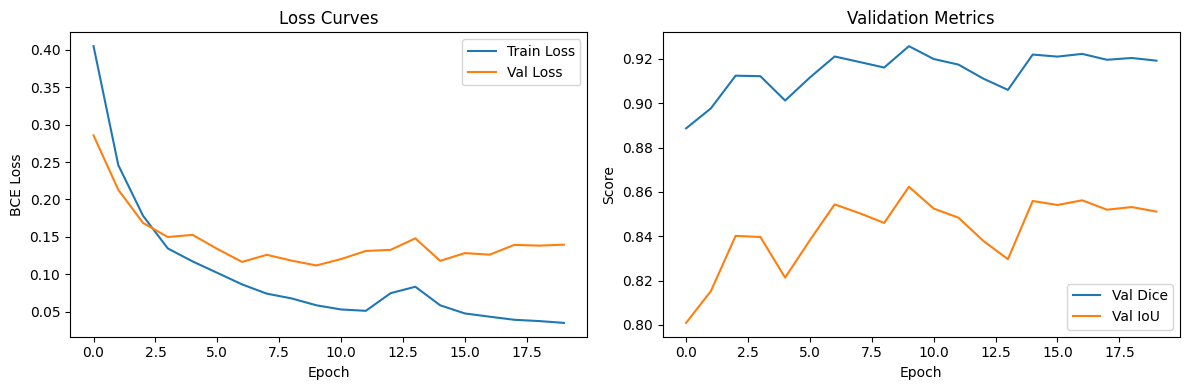

In [ ]:
# Train the Attention U-Net with ResNet34 encoder model
train_losses_att, val_losses_att, val_dices_att, val_ious_att, best_dice_att = train_model(
    attention_unet,
    train_loader,
    val_loader,
    num_epochs=20,
    lr=1e-4,
    save_path="best_attention_unet.pth"
)

#Evaluation

In [ ]:
def evaluate_model(model, dataloader):
    """
    Evaluate a trained segmentation model on a given dataset.

    Args:
        model: Trained PyTorch model
        dataloader: DataLoader containing the evaluation dataset

    Returns:
        mean_dice: Average Dice score across all batches
        mean_iou: Average IoU score across all batches
    """
    # Set model to evaluation mode (disables dropout, batch norm uses running statistics)
    model.eval()

    # Initialize metric calculators and move to device
    dice_metric = BinaryF1Score().to(device)  # Dice coefficient = F1 score for binary segmentation
    iou_metric = BinaryJaccardIndex().to(device)  # Intersection over Union (Jaccard Index)

    # Lists to store scores for each batch
    dice_scores, iou_scores = [], []

    # Disable gradient computation for efficiency during evaluation
    with torch.no_grad():
        # Iterate through all batches in the dataloader
        for imgs, masks in dataloader:
            # Move batch to device (GPU/CPU)
            imgs, masks = imgs.to(device), masks.to(device)

            # Forward pass with sigmoid activation to get probabilities [0, 1]
            preds = torch.sigmoid(model(imgs))

            # Calculate metrics for current batch and store results
            dice_scores.append(dice_metric(preds, masks).cpu().numpy())
            iou_scores.append(iou_metric(preds, masks).cpu().numpy())

    # Return mean scores across all batches
    return np.mean(dice_scores), np.mean(iou_scores)

In [ ]:
# Evaluate the best trained U-Net with ResNet34 encoder on the test dataset
unet_resnet34.load_state_dict(torch.load("best_unet_resnet34.pth"))
dice_unet_test, iou_unet_test = evaluate_model(unet_resnet34, test_loader)
print(f"U-Net ResNet34 Test Dice: {dice_unet_test:.4f}, IoU: {iou_unet_test:.4f}")

U-Net ResNet34 Test Dice: 0.9201, IoU: 0.8536


In [ ]:
# Evaluate the best trained Attention U-Net with ResNet34 encoder on the test dataset
attention_unet.load_state_dict(torch.load("best_attention_unet.pth"))
dice_att_test, iou_att_test = evaluate_model(attention_unet, test_loader)
print(f"Attention U-Net Test Dice: {dice_att_test:.4f}, IoU: {iou_att_test:.4f}")

Attention U-Net Test Dice: 0.9220, IoU: 0.8572


In [ ]:
def visualize_predictions(model1, model2, dataset, device, num_samples=10):
    """
    Visualize comparative predictions from two models alongside ground truth.

    Args:
        model1: First trained model (e.g., regular U-Net)
        model2: Second trained model (e.g., Attention U-Net)
        dataset: PyTorch dataset containing images and masks
        device: Device to run inference on (GPU)
        num_samples: Number of random samples to visualize
    """
    # Set both models to evaluation mode
    model1.eval()
    model2.eval()

    # Visualize specified number of random samples
    for _ in range(num_samples):
        # Select a random sample from the dataset
        idx = random.randint(0, len(dataset)-1)
        img, mask = dataset[idx]

        # Add batch dimension and move to device
        input_img = img.unsqueeze(0).to(device)

        # Run inference on both models
        with torch.no_grad():
            # Model 1 prediction (apply sigmoid for probabilities)
            pred1 = torch.sigmoid(model1(input_img))[0].cpu().numpy()[0]
            # Model 2 prediction (apply sigmoid for probabilities)
            pred2 = torch.sigmoid(model2(input_img))[0].cpu().numpy()[0]

        # Create visualization figure
        plt.figure(figsize=(12,4))

        # Normalize image for display
        img_display = img.permute(1,2,0)
        img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())

        # Plot 1: Original input image
        plt.subplot(1,4,1)
        plt.imshow(img_display)  # Use normalized image
        plt.title("Input Image")
        plt.axis('off')

        # Plot 2: Ground truth mask
        plt.subplot(1,4,2)
        plt.imshow(mask[0], cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        # Plot 3: Model 1 prediction (binary with 0.5 threshold)
        plt.subplot(1,4,3)
        plt.imshow(pred1 > 0.5, cmap='gray')  # Apply binary threshold
        plt.title("U-Net Prediction")
        plt.axis('off')

        # Plot 4: Model 2 prediction (binary with 0.5 threshold)
        plt.subplot(1,4,4)
        plt.imshow(pred2 > 0.5, cmap='gray')  # Apply binary threshold
        plt.title("Attention U-Net Prediction")
        plt.axis('off')

        plt.tight_layout()
        plt.show()


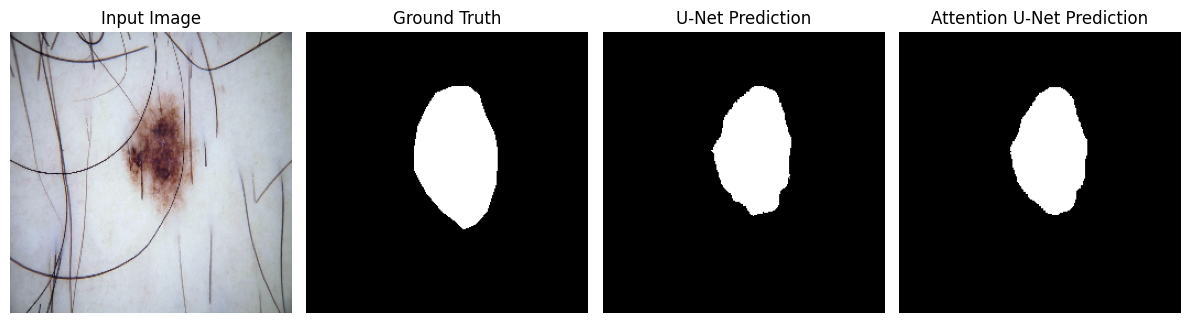

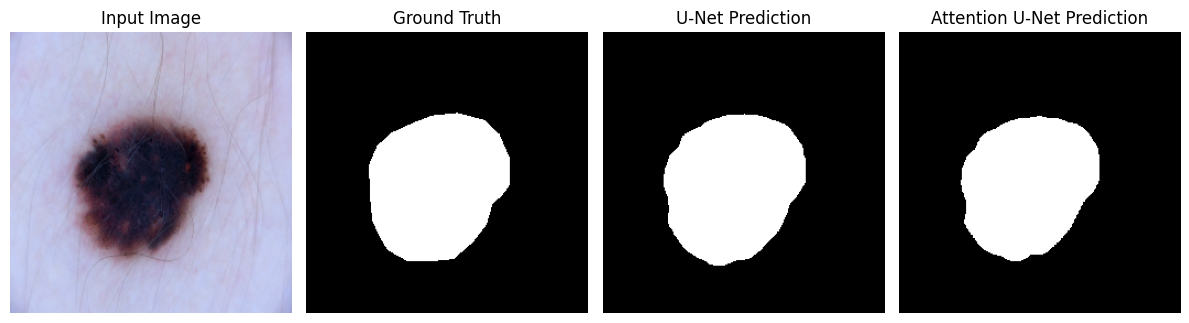

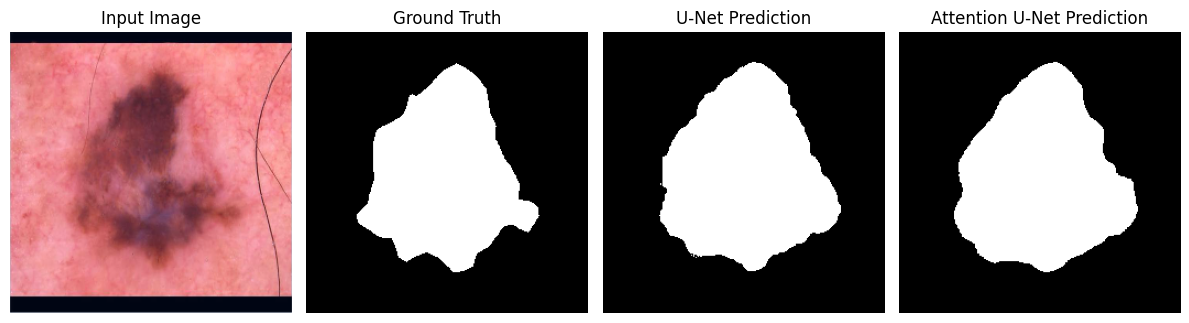

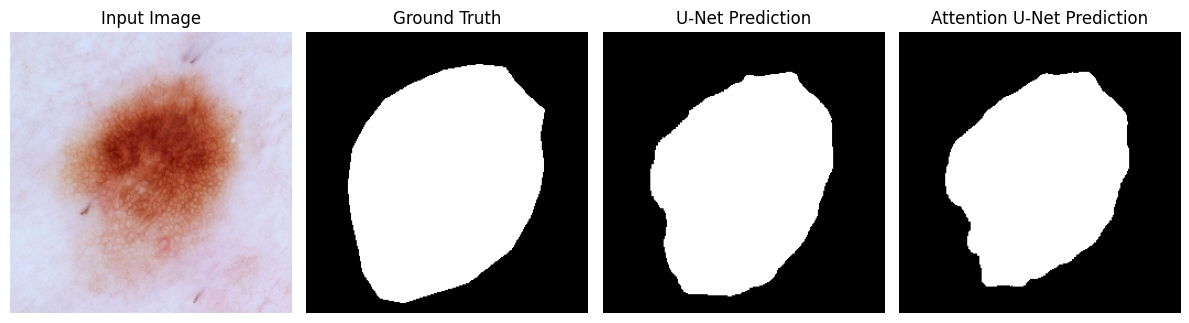

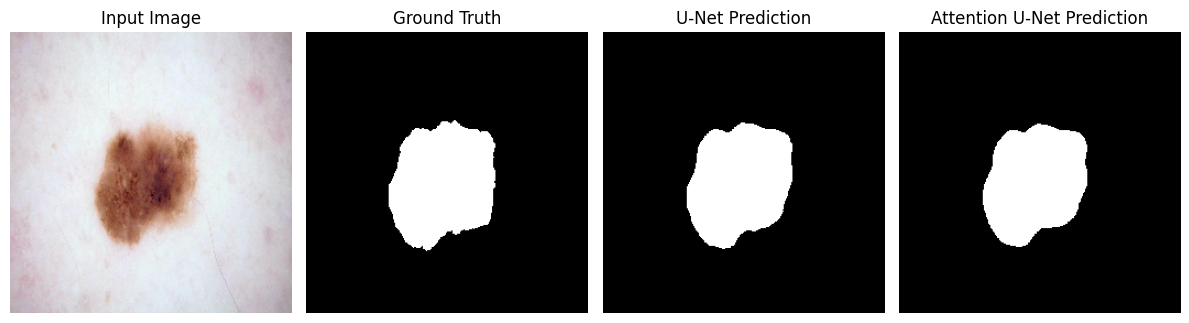

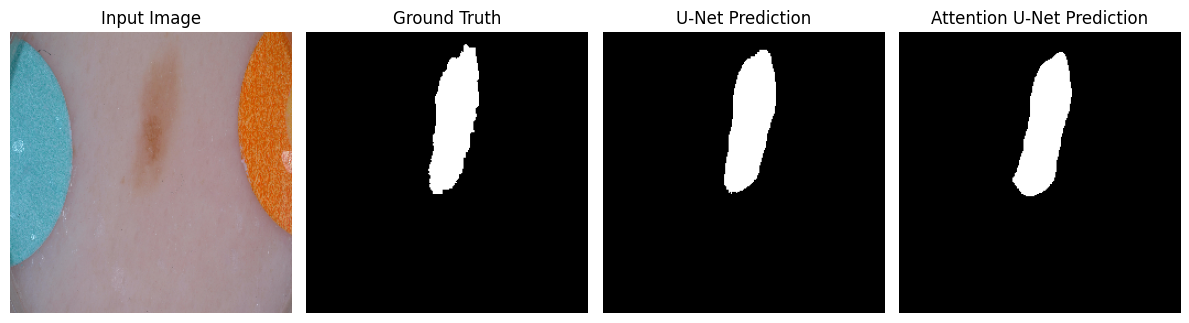

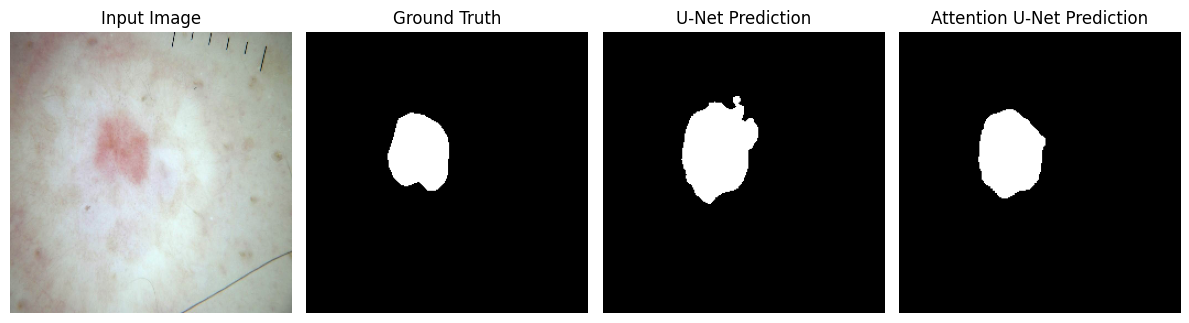

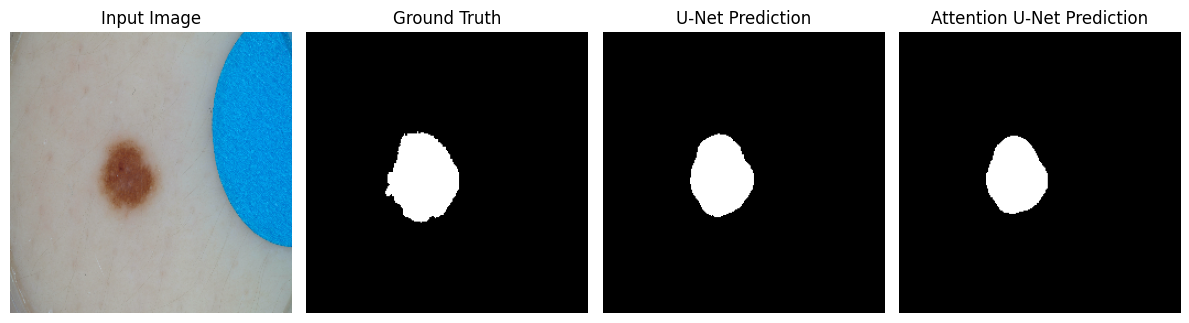

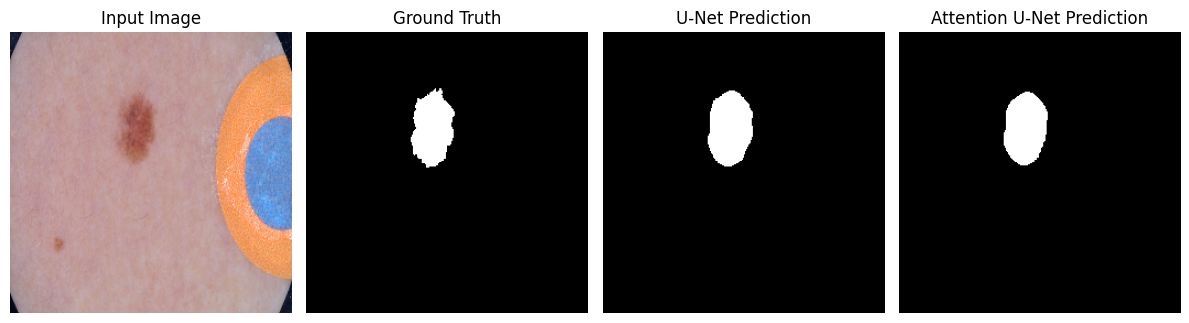

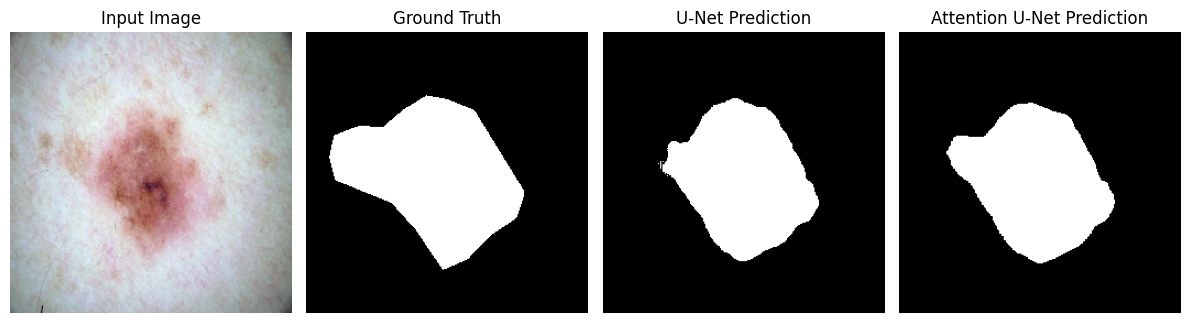

In [ ]:
# Execute the visualization function
visualize_predictions(unet_resnet34, attention_unet, test_dataset, device, 10)

#